In [1]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
import pandas as pd
from IPython.display import clear_output

In [2]:
# os.chdir("G:\Mon Drive\M2\PGM\Wikipedia-Clustering")

In [ ]:
graph_df = pd.read_csv("./data/small_graphs/squirrel/musae_squirrel_edges.csv")
names = pd.read_csv('./data/wiki-topcats-page-names.txt.gz', compression='gzip', header=None, sep='\t', quotechar='"')

G = nx.from_pandas_edgelist(graph_df, source="id1", target="id2")

In [4]:
print(G)
nodes = G.nodes()
n = len(nodes)

Graph with 5201 nodes and 198493 edges


In [5]:
nodes = list(nodes)
print([[node] for node in nodes])

[[3475], [2849], [3106], [808], [4555], [3563], [1527], [3327], [402], [4066], [3908], [2820], [4903], [715], [5112], [817], [4855], [5057], [4481], [3975], [2408], [2539], [4236], [3372], [4303], [4658], [3829], [5078], [313], [4410], [777], [3609], [5122], [4650], [5093], [4862], [2930], [169], [5067], [3700], [2238], [2890], [4544], [2371], [5123], [1481], [1039], [3668], [1654], [1883], [4796], [2173], [3644], [4664], [1316], [4965], [5194], [2219], [3630], [3603], [3253], [3413], [4989], [2972], [5074], [2958], [3691], [4419], [5125], [3909], [4346], [5196], [4365], [3852], [4847], [3730], [3891], [4434], [4730], [4758], [792], [4598], [5050], [5115], [4088], [4471], [3310], [5121], [514], [3078], [5126], [4616], [1548], [4621], [5132], [4625], [4627], [2068], [4629], [5142], [4120], [5145], [5146], [2040], [5148], [4638], [5150], [4640], [4128], [4129], [5160], [2089], [3115], [5164], [5165], [5169], [5174], [2103], [4665], [4158], [1087], [4160], [5186], [5189], [3142], [3143], 

In [ ]:
def bottom_up_clustering(G, limit=50):
    A = nx.adjacency_matrix(G).toarray()
    n = A.shape[0]
    cluster_adjacency = A.copy() - np.diag(np.diagonal(A)) # Every node starts in its own cluster and we remove loops
    cluster_degrees = np.sum(cluster_adjacency, axis=1)

    union_matrix = cluster_degrees[:,None] + cluster_degrees[None,:] - cluster_adjacency
    nonzero_union_matrix = np.maximum(union_matrix, .9)
    criterion_matrix = cluster_adjacency / nonzero_union_matrix # Intersection over union

    cluster_to_nodes = np.eye(n)

    max_crits = []

    for k in range(n, 0, -1):
        if k == limit or k == 1:
            break

        # Find the best clusters to merge
        best_c1, best_c2 = np.unravel_index(np.argmax(criterion_matrix), criterion_matrix.shape)
        max_crit = criterion_matrix[best_c1, best_c2]

        if cluster_adjacency[best_c1, best_c2] == 0:
            bad+=1
            if bad >= 2:
                print("No more good clusters to merge")
                print("C1, C2", best_c1, best_c2)
                print(max_crit)
                print(np.max(criterion_matrix))
                print("Adjacency :", cluster_adjacency[best_c1, best_c2])
                print('Union', cluster_degrees[best_c1] + cluster_degrees[best_c2] - cluster_adjacency[best_c1, best_c2])

                print("Cluster 1 degree:", cluster_degrees[best_c1])
                print("Cluster 2 degree:", cluster_degrees[best_c2])
                print("Cluster 1 nodes:", np.where(cluster_to_nodes[best_c1] > 0)[0])
                print("Cluster 2 nodes:", np.where(cluster_to_nodes[best_c2] > 0)[0])
                break
        else:
            bad=0
        
        max_crits.append(max_crit)
        best_c1, best_c2 = min(best_c1, best_c2), max(best_c1, best_c2)

        if best_c1 == best_c2:
            print("Problem : Merging same cluster")
            print("Adjacency :", cluster_adjacency[best_c1, best_c1])
            print("Criterion :", criterion_matrix[best_c1, best_c1])
            print('Union', cluster_degrees[best_c1] + cluster_degrees[best_c1] - cluster_adjacency[best_c1, best_c1])
            print("Iteration", n-k)
            print("C1, C2", best_c1, best_c2)
            print("k", k)
            raise ValueError("No bueno amigo")

        # Merge clusters
        cluster_to_nodes[best_c1] += cluster_to_nodes[best_c2]
        cluster_to_nodes[best_c2] = cluster_to_nodes[k-1]
        cluster_to_nodes[k-1] = 0

        cluster_adjacency[best_c1] += cluster_adjacency[best_c2]
        cluster_adjacency[best_c1, best_c1] = 0
        cluster_adjacency[:, best_c1] = cluster_adjacency[best_c1]

        cluster_degrees[best_c1] += cluster_degrees[best_c2]

        # Copy cluster k to cluster index best_c2
        if best_c2 != k - 1:
            cluster_adjacency[best_c2] = cluster_adjacency[k - 1]
            cluster_adjacency[:, best_c2] = cluster_adjacency[best_c2]
            cluster_adjacency[best_c2, best_c2] = 0
            cluster_adjacency[best_c1, best_c2] = cluster_adjacency[best_c1, k - 1] + cluster_adjacency[best_c2, k - 1]
            
            criterion_matrix[best_c2] = criterion_matrix[k-1]
            criterion_matrix[:, best_c2] = criterion_matrix[best_c2]
            criterion_matrix[best_c2, best_c2] = 0

            cluster_degrees[best_c2] = cluster_degrees[k - 1]

        cluster_adjacency[k-1] = 0
        cluster_adjacency[:, k-1] = 0 
        cluster_degrees[k-1] = 0     

        # Update Criterion Matrix
        union = cluster_degrees + cluster_degrees[best_c1] - cluster_adjacency[best_c1]
        criterion_matrix[best_c1] = cluster_adjacency[best_c1] / np.maximum(union, .5) # Intersection over union
        criterion_matrix[:, best_c1] = criterion_matrix[best_c1]

        criterion_matrix[k-1] = 0
        criterion_matrix[:, k-1] = 0

        # Reduce dimensions to k*k # actually increases compute time so commented out for now
        #if False and not k%1000:
        #    cluster_adjacency = cluster_adjacency[:k - 1, :k - 1]
        #    cluster_degrees = cluster_degrees[:k - 1]
        #    criterion_matrix = criterion_matrix[:k - 1, :k - 1]

        # Progress bar update
        progress = int((n - k) / (n - limit) * 100)
        str_progress = "=" * progress + ">" * (progress < 100) + " " * (100 - progress)
        clear_output(wait=True)
        print("[", end="")
        print(str_progress, end="")
        print("]")
        print("Iteration", n-k+1)

    # Delete empty clusters
    final_cluster_to_nodes = []
    for i,cluster in enumerate(cluster_to_nodes):
        if cluster.sum() > 10e-2:  # tolerance for digit imprecision
            final_cluster_to_nodes.append(cluster)
    print("total clusters",i+1)

    final_cluster_to_nodes = np.array(final_cluster_to_nodes)

    # Debug prints
    print("Nonempty clusters found:", final_cluster_to_nodes.shape)
    print("Superposition nodes:", np.sum(np.sum(cluster_to_nodes, axis=0) > 1))

    if True:
        plt.plot(max_crits)
        plt.grid(1)
        plt.ylim([0,1])
        plt.title("Max criterion per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Criterion")
        plt.show()

    return final_cluster_to_nodes

[===================================================================================================> ]
Iteration 5171
total clusters 5201
Nonempty clusters found: (30, 5201)
Superposition nodes: 0


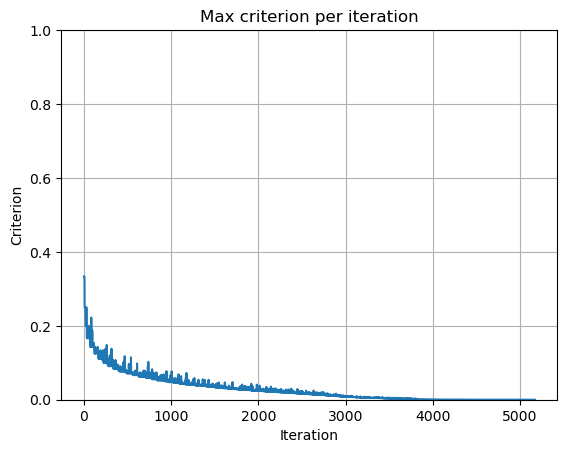

[[1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
clusters = bottom_up_clustering(G, limit = 30)
print(clusters)
np.save("./Clusterings/bottomupv1",clusters)

In [ ]:
aaaaa = np.load("./Clusterings/bottomupv1.npy")

[[1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [38]:
print(np.sum(np.sum(clusters,axis=1) <= 5))

29


In [16]:
node_to_cluster = np.argmax(clusters.T == np.arange(n)[:, None], axis=1)

same_cluster_matrix = node_to_cluster[:, None] == node_to_cluster[None, :]

In [34]:
def global_modularity(same_cluster_matrix, cluster_adjacency, G):
    A = nx.adjacency_matrix(G).toarray()
    out = np.sum(cluster_adjacency) / 2
    m_in = np.sum(A * same_cluster_matrix) / 2
    
    modularity = (m_in - out)
    return modularity / G.number_of_edges() # Normalize

print("Bottom up clustering modularity : ",global_modularity(same_cluster_matrix, clusters, G))

Bottom up clustering modularity :  0.9864554417536134


In [ ]:
pos = nx.spring_layout(G)  # Positionnement des nœuds pour la visualisation

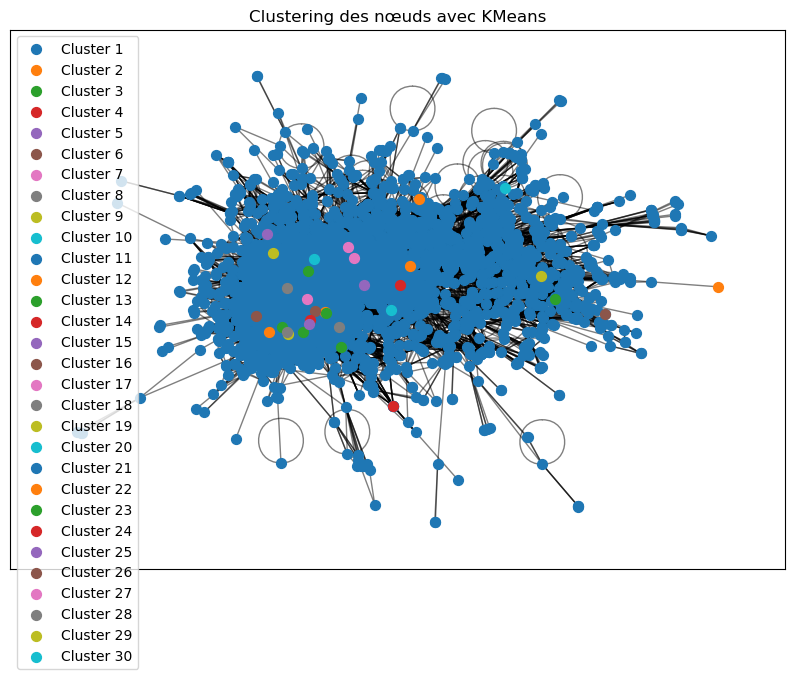

In [28]:
plt.figure(figsize=(10, 7))
for i, cluster in enumerate(clusters):
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=[n for n, l in enumerate(cluster) if l == 1],
        node_size=50,  # Ajuster la taille des nœuds
        node_color=f"C{i}",  # Utiliser une couleur différente pour chaque cluster
        label=f"Cluster {i+1}"
    )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.legend()
plt.title("Clustering des nœuds avec KMeans")
plt.show()

In [ ]:
# Random clustering modularity sanity check

random_clusters = np.random.randint(0, 30, n)
same_cluster_matrix_random = random_clusters[:, None] == random_clusters[None, :]

print("Random assignment clustering modularity : ",global_modularity(same_cluster_matrix_random, clusters, G))

Random assignment clustering modularity :  0.019993148372990485


In [ ]:
for node in nodes:
        print(names[0][node])

3475 Diana Zuckerman
2849 Middle meningeal artery
3106 Auditory fatigue
808 Micrasta
4555 Methanofuran
3563 RUNX2
1527 Tears (X Japan song)
3327 Enucleation (microbiology)
402 Notobubastes
4066 Orgel's rule
3908 Euphorbia palmeri
2820 Corrugator supercilii muscle
4903 Postsynaptic potential
715 Cordillerita
5112 Crystallin
817 Neomastogenius
4855 ErdheimChester disease
5057 Operator (biology)
4481 Glucosylceramidase
3975 Euphorbia kuwaleana
2408 Anterior nuclei of thalamus
2539 Clobenpropit
4236 Formyltetrahydrofolate dehydrogenase
3372 Rheobase
4303 Azobenzene reductase
4658 Cidofovir
3829 Euphorbia zakamenae
5078 P element
313 Chalcophora
4410 ATP adenylyltransferase
777 Paraancylotela
3609 Capitate bone
5122 Assisted reproductive technology
4650 Abacavir
5093 Personal genomics
4862 Paroxysmal depolarizing shift
2930 Facial muscles
169 Sarver, Pennsylvania
5067 Prophage
3700 Patellar reflex
2238 Day care sex abuse hysteria
2890 Mylohyoid line
4544 6-pyruvoyltetrahydropterin synthase


In [ ]:
#Antoine
#Tiens melnvin tu peux utiliser ce truc pour voir les noms qui ressortent de chaque cluster

from wordcloud import WordCloud

# Combinez toutes les phrases du cluster
text = ' '.join(cluster_phrases).lower()
print(f"Cluster {cluster_id} : {text[:100]}...")

# Générez le Word Cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Affichez le Word Cloud
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f"Word Cloud for Cluster {cluster_id}")
plt.show()